# Imports

In [1]:
import collections
import datetime
import functools
import math
import os
import sys
from typing import Callable, Optional

if "PyTorch_VAE" not in sys.path:
    sys.path.append("PyTorch_VAE")

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from tqdm.notebook import tqdm, trange

from PyTorch_VAE import models
from diffusion_policy.common.sampler import get_val_mask
from diffusion_policy.common.pytorch_util import compute_conv_output_shape
from diffusion_policy.dataset.pusht_image_dataset import PushTImageDataset
from diffusion_policy.model.diffusion import conditional_unet1d

# Plotting

In [2]:
def plot_losses(train_losses, test_losses):
    # Plot train and test losses.
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(
        np.linspace(0, len(train_losses), len(test_losses)),
        test_losses,
        label="Test Loss",
    )
    # Remove outliers for better visualization
    # plt.ylim(0, 0.01)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Load dataset

In [3]:
path = "/nas/ucb/ebronstein/lsdp/diffusion_policy/data/pusht/pusht_cchi_v7_replay.zarr"
# path = "/home/tsadja/data_diffusion/pusht/pusht_cchi_v7_replay.zarr"
# path = '/home/matteogu/ssd_data/data_diffusion/pusht/pusht_cchi_v7_replay.zarr'

dataset = PushTImageDataset(path)
full_dataset = torch.from_numpy(dataset.replay_buffer["img"]).permute(0, 3, 1, 2)
N, C, H, W = full_dataset.shape

In [4]:
def normalize_pn1(x, min_val, max_val):
    # Normalize to [0, 1]
    nx = (x - min_val) / (max_val - min_val)

    # Normalize to [-1, 1]
    return nx * 2 - 1


def denormalize_pn1(nx, min_val, max_val):
    # Denormalize from [-1, 1]
    x = (nx + 1) / 2

    # Denormalize from [0, 1]
    return x * (max_val - min_val) + min_val


# Make the state normalizer.
max_state = dataset.replay_buffer["state"].max(axis=0)

# TODO: does this make a difference?
# min_state = np.zeros_like(max_state)
min_state = dataset.replay_buffer["state"].min(axis=0)

In [5]:
min_state, max_state

(array([1.3456424e+01, 3.2938293e+01, 5.7471767e+01, 1.0827995e+02,
        2.1559125e-04], dtype=float32),
 array([496.14618  , 510.9579   , 439.9153   , 485.6641   ,   6.2830877],
       dtype=float32))

In [6]:
class EpisodeDataset(Dataset):
    def __init__(
        self,
        dataset,
        n_obs_history=1,
        n_pred_horizon=1,
        episode_idxs=None,
        include_keys: Optional[list[str]] = None,
        process_fns: Optional[dict[str, Callable]] = None,
        device: str = "cpu",
    ):
        """
        Initialize the dataset with the main dataset object that contains
        the replay_buffer. Also, specify the lengths of observation history
        and prediction horizon.
        """
        self.dataset = dataset
        self.n_obs_history = n_obs_history
        self.n_pred_horizon = n_pred_horizon
        self.episode_idxs = list(episode_idxs)
        self.include_keys = set(include_keys) if include_keys is not None else None
        if not self.include_keys:
            raise ValueError("At least one key must be included in the dataset.")
        self.process_fns = process_fns
        self.device = device
        self.prepare_data()

    def prepare_data(self):
        """
        Preprocess the episodes to create a flat list of samples.
        Each sample is a tuple of dictionaries: (obs_history, pred_horizon).
        """
        self.samples = []

        if self.episode_idxs is None:
            self.episode_idxs = range(self.dataset.replay_buffer.n_episodes)

        for episode_idx in tqdm(self.episode_idxs, desc="Preparing data"):
            episode = self.dataset.replay_buffer.get_episode(episode_idx)

            obs = {}

            if self.include_keys is None or "img" in self.include_keys:
                img = episode["img"].transpose(0, 3, 1, 2)  # CHW format
                if "img" in self.process_fns:
                    img = self.process_fns["img"](img)
                obs["img"] = torch.tensor(img, dtype=torch.float32).to(self.device)

            if self.include_keys is None or "action" in self.include_keys:
                action = episode["action"]
                if "action" in self.process_fns:
                    action = self.process_fns["action"](action)
                obs["action"] = torch.tensor(action, dtype=torch.float32).to(
                    self.device
                )

            if self.include_keys is None or "state" in self.include_keys:
                state = episode["state"]
                if "state" in self.process_fns:
                    state = self.process_fns["state"](state)
                obs["state"] = torch.tensor(state, dtype=torch.float32).to(self.device)

            # Iterate through the episode to create samples with observation history and prediction horizon
            n_obs = len(list(obs.values())[0])
            for i in range(n_obs - self.n_obs_history - self.n_pred_horizon + 1):
                obs_history = {}
                pred_horizon = {}

                for key, value in obs.items():
                    obs_history[key] = value[i : i + self.n_obs_history]
                    pred_horizon[key] = value[
                        i
                        + self.n_obs_history : i
                        + self.n_obs_history
                        + self.n_pred_horizon
                    ]

                self.samples.append((obs_history, pred_horizon))

    def __len__(self):
        """
        Return the total number of samples across all episodes.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Return the idx-th sample from the dataset.
        """
        obs_history, pred_horizon = self.samples[idx]

        # Convert data to PyTorch tensors and ensure the data type is correct
        # for key, value in obs_history.items():
        #     obs_history[key] = torch.tensor(value, dtype=torch.float32)
        # for key, value in pred_horizon.items():
        #     pred_horizon[key] = torch.tensor(value, dtype=torch.float32)

        return obs_history, pred_horizon

# Diffusion

## Models

In [7]:
class VanillaVAE(models.VanillaVAE):

    def __init__(
        self,
        in_channels: int,
        in_height: int,
        in_width: int,
        latent_dim: int,
        hidden_dims: Optional[list] = None,
        **kwargs,
    ) -> None:
        models.BaseVAE.__init__(self)

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        kernel_size = 3
        stride = 2
        padding = 1
        dilation = 1
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels=h_dim,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding,
                        dilation=dilation,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim

        self.conv_out_shape = compute_conv_output_shape(
            H=in_height,
            W=in_width,
            padding=padding,
            stride=stride,
            kernel_size=kernel_size,
            dilation=dilation,
            num_layers=len(hidden_dims),
            last_hidden_dim=hidden_dims[-1],
        )
        conv_out_size = np.prod(self.conv_out_shape)

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(conv_out_size, latent_dim)
        self.fc_var = nn.Linear(conv_out_size, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, conv_out_size)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                hidden_dims[-1],
                hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, *self.conv_out_shape)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result


class DiffusionMLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden_dims: list[int]):
        super(DiffusionMLP, self).__init__()

        layers = []
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        """Run a forward pass.

        Args:
            x (torch.Tensor): Data with shape [batch_size, n_history, input_dim].
            t (torch.Tensor): Time embedding with shape [batch_size].
        """
        # print("x:", x.shape)
        flat_x = x.flatten(1)  # [batch_size, n_history * input_dim]
        # print("flat_x:", flat_x.shape)
        # print("t:", t.shape)
        t = t.reshape(-1, 1)
        # print("t:", t.shape)
        xt = torch.cat([flat_x, t], dim=1)
        # print("xt:", xt.shape)
        out = self.net(xt)
        # print("out:", out.shape)
        out = out.reshape(x.shape)
        # print("out:", out.shape)
        return out

## Train/eval impl

In [218]:
def warmup_cosine_decay_scheduler(optimizer, warmup_steps, total_steps):
    """
    Creates a scheduler with warmup followed by cosine decay.

    Args:
        optimizer: Optimizer linked to the model parameters.
        warmup_steps: Number of steps for the warmup phase.
        total_steps: Total number of steps in the training.
    """

    def lr_lambda(current_step):
        if current_step < warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, warmup_steps))
        # Cosine decay
        progress = float(current_step - warmup_steps) / float(
            max(1, total_steps - warmup_steps)
        )
        return 0.5 * (1.0 + np.cos(np.pi * progress))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def dropout_classes(y, null_class, dropout_prob=0.1):
    """Randomly dropout classes with a given probability."""
    dropout_mask = torch.rand(y.shape) < dropout_prob
    y[dropout_mask] = null_class
    return y


class Diffusion(object):
    def __init__(
        self,
        train_data=None,
        test_data=None,
        model=None,
        batch_size=1024,
        n_epochs=100,
        n_warmup_steps=100,
        has_labels=False,
        obs_normalizer=None,
        optim_kwargs: dict = None,
        device: str = "cuda",
    ):
        if has_labels:
            raise NotImplementedError()

        self.n_epochs = n_epochs
        self.has_labels = has_labels
        self.device = device

        self.obs_normalizer = (
            obs_normalizer if obs_normalizer is not None else lambda x: x
        )

        # Data loaders
        if isinstance(train_data, torch.utils.data.DataLoader):
            assert isinstance(test_data, torch.utils.data.DataLoader)
            self.train_loader = train_data
            self.test_loader = test_data
            train_data_shape = None
        elif train_data is not None:
            assert test_data is not None
            train_data_shape = train_data.shape
            self.train_loader, self.test_loader = self.create_loaders(
                train_data, test_data, batch_size
            )
        else:
            self.train_loader = None
            self.test_loader = None

        if model is None:
            assert train_data_shape is not None and len(train_data_shape) == 2
            input_dim = train_data_shape[1]
            self.model = DiffusionMLP(input_dim, input_dim)
        else:
            self.model = model
        self.model = self.model.to(device)

        def model_with_labels(x, labels, t, **kwargs):
            return self.model(x, labels, t, **kwargs)

        def model_without_labels(x, labels, t, **kwargs):
            return self.model(x, t, **kwargs)

        if has_labels:
            self.model_fn = model_with_labels
        else:
            self.model_fn = model_without_labels

        # Optimizer
        optim_kwargs = optim_kwargs or {}
        self.optimizer = torch.optim.Adam(self.model.parameters(), **optim_kwargs)

        # LR scheduler
        if self.train_loader is not None:
            n_iters_per_epoch = len(self.train_loader)
            n_iters = n_epochs * n_iters_per_epoch
            self.scheduler = warmup_cosine_decay_scheduler(
                self.optimizer, n_warmup_steps, n_iters
            )
        else:
            self.scheduler = None

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(
            torch.load(path, map_location=torch.device(self.device))
        )

    def create_loaders(self, train_data, test_data, batch_size):
        train_data = torch.tensor(train_data, dtype=torch.float32)
        test_data = torch.tensor(test_data, dtype=torch.float32)

        train_loader = torch.utils.data.DataLoader(
            train_data, batch_size=batch_size, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            test_data, batch_size=batch_size, shuffle=False
        )
        return train_loader, test_loader

    def get_alpha(self, t):
        return torch.cos(np.pi / 2 * t).to(self.device)

    def get_sigma(self, t):
        return torch.sin(np.pi / 2 * t).to(self.device)

    def compute_loss(self, x, obs, labels=None):
        batch_size = x.shape[0]

        # Step 1: Sample diffusion timestep uniformly in [0, 1]
        t = torch.rand(batch_size, device=self.device)  # [batch_size]

        # Step 2: Compute noise-strength
        alpha_t = self.get_alpha(t)
        sigma_t = self.get_sigma(t)

        # Step 3: Apply forward process
        epsilon = torch.randn_like(x, device=self.device)
        exp_shape = [batch_size] + [1] * (len(x.shape) - 1)
        alpha_t = alpha_t.view(exp_shape)
        sigma_t = sigma_t.view(exp_shape)
        # Print shapes
        # print("x:", x.shape)
        # print("alpha_t:", alpha_t.shape)
        # print("sigma_t:", sigma_t.shape)
        # print("epsilon:", epsilon.shape)
        x_t = alpha_t * x + sigma_t * epsilon  # x.shape

        # Flatten obs
        obs = obs.flatten(1)

        # Step 4: Estimate epsilon
        eps_hat = self.model_fn(x_t, labels, t, global_cond=obs)
        # print("eps_hat:", eps_hat.shape)

        # Step 5: Optimize the loss
        loss = (epsilon - eps_hat).pow(2).mean()
        return loss

    def eval(self, test_loader, obs_key: str = "state"):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for x in test_loader:
                if self.has_labels:
                    raise NotImplementedError()
                    x, labels = x
                    labels = labels.to(self.device)
                else:
                    labels = None
                obs_history, pred_horizon = x
                obs = obs_history[obs_key].to(self.device)
                obs = self.obs_normalizer(obs)

                loss = self.compute_loss(obs, labels)
                total_loss += loss.item() * obs.shape[0]

        return total_loss / len(test_loader.dataset)

    def train(
        self,
        log_freq=100,
        save_freq: int = 10,
        obs_key: str = "state",
        process_labels_fn=None,
        save_dir=None,
        wandb_run=None,
    ):
        if wandb_run is not None:
            log_freq = None
        if save_dir is not None:
            # Get the current timestamp and save it as a new directory.
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            save_dir = os.path.join(save_dir, timestamp)
            os.makedirs(save_dir)

        train_losses = []
        test_losses = [self.eval(self.test_loader, obs_key=obs_key)]

        iter = 0
        for epoch in range(self.n_epochs):
            if wandb_run is not None:
                wandb_run.log({"epoch": epoch + 1})
            epoch_train_losses = []
            # grad_norms = []
            self.model.train()

            for x in self.train_loader:
                if self.has_labels:
                    raise NotImplementedError()
                    x, labels = x
                    labels = labels.to(self.device)
                    if process_labels_fn is not None:
                        labels = process_labels_fn(labels)
                else:
                    labels = None

                obs_history, pred_horizon = x
                obs = obs_history[obs_key].to(self.device)
                # print("obs:", obs.shape)
                obs = self.obs_normalizer(obs)
                # print("obs:", obs.shape)
                pred = pred_horizon[obs_key].to(self.device)

                self.optimizer.zero_grad()
                loss = self.compute_loss(pred, obs, labels)
                loss.backward()

                # Compute the norm of gradients
                total_norm = 0
                for p in self.model.parameters():
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
                total_norm = total_norm**0.5
                if wandb_run is not None:
                    wandb_run.log({"grad_norm": total_norm})
                    wandb_run.log({"batch_loss": loss.item()})
                # grad_norms.append(total_norm)

                self.optimizer.step()
                self.scheduler.step()

                epoch_train_losses.append(loss.item())

                if log_freq is not None and iter % log_freq == 0:
                    print(f"Epoch {epoch+1}, iter {iter}, Loss: {loss.item()}")

                iter += 1

            train_losses.extend(epoch_train_losses)
            test_losses.append(self.eval(self.test_loader, obs_key=obs_key))

            if save_dir is not None and epoch % save_freq == 0:
                self.save(os.path.join(save_dir, f"diffusion_model_epoch_{epoch}.pt"))

        if save_dir is not None:
            self.save(os.path.join(save_dir, "diffusion_model_final.pt"))
            np.save(os.path.join(save_dir, "train_losses.npy"), train_losses)
            np.save(os.path.join(save_dir, "test_losses.npy"), test_losses)

        return train_losses, test_losses


def ddpm_update(
    x,
    eps_hat,
    alpha_t,
    alpha_tm1,
    sigma_t,
    sigma_tm1,
    clip=None,
    clip_noise=None,
    device: str = "cuda",
):
    # assert not torch.isnan(eps_hat).any()
    # assert not torch.isnan(sigma_t).any()
    # assert alpha_t.abs().min() > 1e-6
    if torch.isnan(eps_hat).any():
        print("nan eps_hat")
    if torch.isnan(sigma_t).any():
        print("nan sigma_t")
    if alpha_t.abs().min() < 1e-6:
        print("alpha_t is too small")
    eta_t = sigma_tm1 / sigma_t * torch.sqrt(1 - alpha_t.pow(2) / alpha_tm1.pow(2))
    # assert not torch.isnan(eta_t).any()
    if torch.isnan(eta_t).any():
        print("nan eta_t")
    x_tm1_mean = (x - sigma_t * eps_hat) / alpha_t
    # assert not torch.isnan(x_tm1_mean).any()
    if torch.isnan(x_tm1_mean).any():
        print("nan x_tm1_mean")
    if clip is not None:
        min, max = clip
        x_tm1_mean = torch.clamp(x_tm1_mean, min, max)
    update_term = alpha_tm1 * x_tm1_mean
    # assert not torch.isnan(update_term).any()
    if torch.isnan(update_term).any():
        print("nan update_term")
    noise_term = (
        torch.sqrt(torch.clamp(sigma_tm1.pow(2) - eta_t.pow(2), min=0)) * eps_hat
    )
    # assert not torch.isnan(noise_term).any()
    if torch.isnan(noise_term).any():
        print("nan noise_term")
    random_noise = torch.randn_like(x, device=device)
    if clip_noise:
        random_noise = torch.clamp(random_noise, clip_noise[0], clip_noise[1])
    random_noise *= eta_t
    x_tm1 = update_term + noise_term + random_noise
    return x_tm1


def sample(
    model,
    num_samples,
    return_steps,
    data_shape,
    data_loader: Optional[torch.utils.data.DataLoader] = None,
    labels=None,
    clip=None,
    clip_noise=None,
    cfg_w=None,
    null_class=None,
    obs_key: str = "state",
    device: str = "cuda",
):
    model.model.eval()
    if not isinstance(data_shape, (list, tuple)):
        data_shape = (data_shape,)
    x_shape = (num_samples,) + tuple(data_shape)
    exp_shape = [num_samples] + [1] * len(data_shape)
    samples = []  # [num_labels, len(return_steps), num_samples, *data_shape]

    if cfg_w is not None:
        assert labels is not None
        assert null_class is not None
        with torch.no_grad():
            null_class = torch.tensor(
                null_class, dtype=torch.int32, device=device
            ).expand(num_samples)

    if labels is None:
        labels = [None]
        model_kwargs = {}
    else:
        model_kwargs = {"training": False}

    for label in labels:
        label_samples = []
        with torch.no_grad():
            if label is not None:
                label = torch.tensor(label, dtype=torch.int32, device=device)
                label = label.expand(num_samples)
            for num_steps in return_steps:
                ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)

                if data_loader is None:
                    x_shape = (num_samples,) + tuple(data_shape)
                    obs = None
                else:
                    n_obs = 0
                    obs = []
                    for obs_history, _ in data_loader:
                        # [batch_size, n_obs_history, state_dim]
                        obs_history = obs_history[obs_key]
                        # Concatenate observations along the time dimension.
                        obs_history = obs_history.flatten(1)
                        obs.append(obs_history)
                        n_obs += obs_history.shape[0]
                        if n_obs >= num_samples:
                            break
                    obs = torch.cat(obs, dim=0)[:num_samples].to(device)
                    print("obs:", obs.shape)

                x = torch.randn(x_shape, device=device)
                print("x:", x.shape)
                for i in range(num_steps):
                    t = torch.tensor([ts[i]], dtype=torch.float32, device=device)
                    tm1 = torch.tensor([ts[i + 1]], dtype=torch.float32, device=device)

                    alpha_t = model.get_alpha(t).expand(exp_shape)
                    alpha_tm1 = model.get_alpha(tm1).expand(exp_shape)
                    sigma_t = model.get_sigma(t).expand(exp_shape)
                    sigma_tm1 = model.get_sigma(tm1).expand(exp_shape)

                    # assert not torch.isnan(x).any(), f"step: {i}"
                    if torch.isnan(x).any():
                        print("nan x at step = ", i)
                    eps_hat = model.model_fn(
                        x, label, t.expand(num_samples), global_cond=obs, **model_kwargs
                    )
                    # assert not torch.isnan(eps_hat).any(), f"step: [{i}/{num_steps}], t: {t}"
                    if torch.isnan(eps_hat).any():
                        print("nan eps_hat step = ", i)
                        breakpoint()
                    if cfg_w is not None:
                        eps_hat_null = model.model_fn(
                            x, null_class, t.expand(num_samples), **model_kwargs
                        )
                        eps_hat = eps_hat_null + cfg_w * (eps_hat - eps_hat_null)

                    x = ddpm_update(
                        x,
                        eps_hat,
                        alpha_t,
                        alpha_tm1,
                        sigma_t,
                        sigma_tm1,
                        clip=clip,
                        clip_noise=clip_noise,
                        device=device,
                    )

                label_samples.append(x.cpu().detach().numpy())
            samples.append(label_samples)

    # Squeeze out the label and return_steps dimensions if there's only.
    samples = np.array(samples)
    if len(labels) == 1:
        samples = samples.squeeze(0)
    return samples


def _get_alpha_sigma(t):
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)


def _expand(t, data_shape):
    for _ in range(len(data_shape)):
        t = t[..., None]
    return t


def _x_hat(x_t, eps_hat, t, data_shape):
    alpha_t, sigma_t = _get_alpha_sigma(_expand(t, data_shape))
    return (x_t - sigma_t * eps_hat) / alpha_t


@torch.no_grad()
def sample_pieter(
    model_fn, n, num_steps, data_shape, clip_denoised=False, cfg_val=None
):

    ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1, dtype=np.float32)
    x = torch.randn(n, *data_shape, dtype=torch.float32).cuda()
    for i in range(num_steps):
        t_cur = torch.full((n,), ts[i], dtype=torch.float32).cuda()
        t_next = torch.full((n,), ts[i + 1], dtype=torch.float32).cuda()

        alpha_cur, sigma_cur = _get_alpha_sigma(_expand(t_cur, data_shape))
        alpha_next, sigma_next = _get_alpha_sigma(_expand(t_next, data_shape))
        ddim_sigma = (sigma_next / sigma_cur) * torch.sqrt(
            1 - alpha_cur**2 / alpha_next**2
        )

        if cfg_val is None:
            eps_hat = model_fn(x, None, t_cur)  # Labels are None.
        else:
            raise NotImplementedError()
            # eps_hat_cond = model_fn(x, t_cur)
            # eps_hat_uncond = model_fn(x, t_cur, dropout_cond=True)
            # eps_hat = eps_hat_uncond + cfg_val * (eps_hat_cond - eps_hat_uncond)

        x_hat = _x_hat(x, eps_hat, t_cur, data_shape)
        if clip_denoised:
            x_hat = torch.clamp(x_hat, -1, 1)
        x = (
            alpha_next * x_hat
            + torch.sqrt((sigma_next**2 - ddim_sigma**2).clamp(min=0)) * eps_hat
            + ddim_sigma * torch.randn_like(eps_hat)
        )
    # if self.decode_fn is not None:
    #     x = self.decode_fn(x)
    return x

In [180]:
obs, pred = next(iter(train_loader))

## Make data loaders

In [169]:
# Make train and val loaders
val_mask = get_val_mask(dataset.replay_buffer.n_episodes, 0.1)
val_idxs = np.where(val_mask)[0]
train_idxs = np.where(~val_mask)[0]
# train_idxs = [0]
# val_idxs = [1]

# Make the episode dataset and create a DataLoader.
batch_size = 256
n_obs_history = 0
n_pred_horizon = 8


def get_normalized_T_xy(state):
    """Get the normalized x, y coordinates of the T.

    Args:
        state (np.ndarray): State with shape (n, 5).
    """
    xy = state[:, 2:4]
    return normalize_pn1(xy, min_val=min_state[2:4], max_val=max_state[2:4])


device = "cuda"
obs_key = "img"

if obs_key == "state":
    state_normalizer = functools.partial(
        normalize_pn1, min_val=min_state, max_val=max_state
    )
    process_fns = {"state": state_normalizer}
    # process_fns = {"state": get_normalized_T_xy}

    include_keys = ["state"]
elif obs_key == "img":
    latent_dim = 32
    vae_model_path = "models/pusht_vae/vae_32_20240403.pt"

    vae_model = VanillaVAE(
        in_channels=C,
        in_height=H,
        in_width=W,
        latent_dim=latent_dim,
        hidden_dims=[32, 64, 128, 256, 512],
    ).to(device)
    vae_model.load_state_dict(torch.load(vae_model_path))
    STATE_DIM = latent_dim

    def get_latent(x, vae_model, device):
        x = x / 255.0
        x = 2.0 * x - 1.0
        return vae_model.encode(torch.from_numpy(x).to(device))[0].detach()

    normalize_encoder_input = functools.partial(
        get_latent, vae_model=vae_model, device=device
    )
    process_fns = {"img": normalize_encoder_input}

include_keys = [obs_key]
train_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=train_idxs,
    include_keys=include_keys,
    process_fns=process_fns,
    device=device,
)
val_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=val_idxs,
    include_keys=include_keys,
    process_fns=process_fns,
    device=device,
)
train_loader = torch.utils.data.DataLoader(
    train_episode_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_episode_dataset, batch_size=batch_size, shuffle=False
)

Preparing data:   0%|          | 0/185 [00:00<?, ?it/s]

/tmp/ipykernel_4042820/2220384273.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs["img"] = torch.tensor(img, dtype=torch.float32).to(self.device)


Preparing data:   0%|          | 0/21 [00:00<?, ?it/s]

In [170]:
# Normalization sanity check
obs_history_min = collections.defaultdict(lambda: np.inf)
obs_history_max = collections.defaultdict(lambda: -np.inf)
pred_horizon_min = collections.defaultdict(lambda: np.inf)
pred_horizon_max = collections.defaultdict(lambda: -np.inf)

for obs_history, pred_horizon in train_loader:

    for key, value in obs_history.items():
        # print(key, value.shape)
        # print("min:", value.min(axis=0), "max:", value.max(axis=0))
        obs_history_min[key] = np.minimum(
            obs_history_min[key], value.min(axis=0).values.cpu().numpy()
        )
        obs_history_max[key] = np.maximum(
            obs_history_max[key], value.max(axis=0).values.cpu().numpy()
        )

    for key, value in pred_horizon.items():
        # print(key, value.shape)
        # print("min:", value.min(axis=0), "max:", value.max(axis=0))
        pred_horizon_min[key] = np.minimum(
            pred_horizon_min[key], value.min(axis=0).values.cpu().numpy()
        )
        pred_horizon_max[key] = np.maximum(
            pred_horizon_max[key], value.max(axis=0).values.cpu().numpy()
        )

    # for key, value in pred_horizon.items():
    # print(key, value.shape)
    # print("min:", value.min(axis=0), "max:", value.max(axis=0))

print(obs_history_min, obs_history_max)
print(pred_horizon_min, pred_horizon_max)

defaultdict(<function <lambda> at 0x7f9bc0d8b430>, {'img': array([], shape=(0, 32), dtype=float32)}) defaultdict(<function <lambda> at 0x7f9b10348af0>, {'img': array([], shape=(0, 32), dtype=float32)})
defaultdict(<function <lambda> at 0x7f9b000473a0>, {'img': array([[-7.8454404, -6.5323033, -5.775402 , -6.109601 , -5.581302 ,
        -6.485052 , -7.088742 , -5.4812813, -6.219321 , -5.428675 ,
        -6.4368796, -5.863816 , -6.689462 , -6.1809216, -7.9791646,
        -6.699121 , -7.0784335, -6.9839077, -5.441411 , -7.204604 ,
        -6.28745  , -6.8623734, -5.4015145, -6.140817 , -5.644804 ,
        -5.4820995, -6.995715 , -5.9387927, -5.804771 , -6.0912395,
        -7.075579 , -5.9993477],
       [-7.8454404, -6.5323033, -5.775402 , -6.109601 , -5.581302 ,
        -6.485052 , -7.088742 , -5.4812813, -6.219321 , -5.428675 ,
        -6.1992874, -5.863816 , -6.689462 , -6.1809216, -7.9791646,
        -6.699121 , -7.0784335, -6.9839077, -5.441411 , -7.204604 ,
        -6.28745  , -6.862

## Train

In [203]:
latent_diffusion = True
global_cond = True

# wandb_run = wandb.init(project='check_norms', name='first_run', reinit=True)
wandb_run = None

# MLP model (doesn't work well)
# input_dim + 1 because the time step is concatenated to the state.
# input_dim = n_obs_history * STATE_DIM + 1
# hidden_dims = [256] * 4
# diff_model = DiffusionMLP(input_dim, input_dim - 1, hidden_dims).to(device)

global_cond_dim = STATE_DIM * n_obs_history if global_cond else None
diff_model = conditional_unet1d.ConditionalUnet1D(
    input_dim=STATE_DIM,
    down_dims=[128, 256, 512, 1024],
    global_cond_dim=global_cond_dim,
).to(device)

optim_kwargs = dict(lr=3e-4)
diffusion = Diffusion(
    train_data=train_loader,
    test_data=val_loader,
    model=diff_model,
    n_epochs=10,
    optim_kwargs=optim_kwargs,
    device=device,
)

# load_dir = "models/diffusion/pusht_1dconv_128_256_512_1024/2024-04-25_23-29-40/2024-04-25_23-29-40"
# load_dir = "models/diffusion/pusht_1dconv_latent_128_256_512_1024/2024-04-26_00-45-03"
# load_dir = "models/diffusion/pusht-1dconv_state_128_256_512_1024-obs_8-pred_8/2024-04-27_22-07-27"
# load_dir = "models/diffusion/pusht-1dconv_latent_128_256_512_1024-obs_8-pred_8/2024-04-28_00-43-07"
# load_dir = "models/diffusion/use_ema_helper/pusht_unet1d_img_128_256_512_1024_edim_256obs_8_pred_8_bs_256_lr_0.001_e_500/2024-05-04_22-16-07"
load_dir = "models/diffusion/use_ema_helper/pusht_unet1d_img_128_256_512_1024_edim_256obs_0_pred_8_bs_256_lr_0.001_e_200/2024-05-04_22-44-11"

epoch = None

if load_dir is not None:
    if epoch is not None:
        filename = f"diffusion_model_epoch_{epoch}.pt"
    else:
        filename = "diffusion_model_final.pt"

    diffusion.load(os.path.join(load_dir, filename))
    train_losses = np.load(os.path.join(load_dir, "train_losses.npy"))
    test_losses = np.load(os.path.join(load_dir, "test_losses.npy"))
else:
    train_losses, test_losses = diffusion.train(wandb_run=wandb_run)

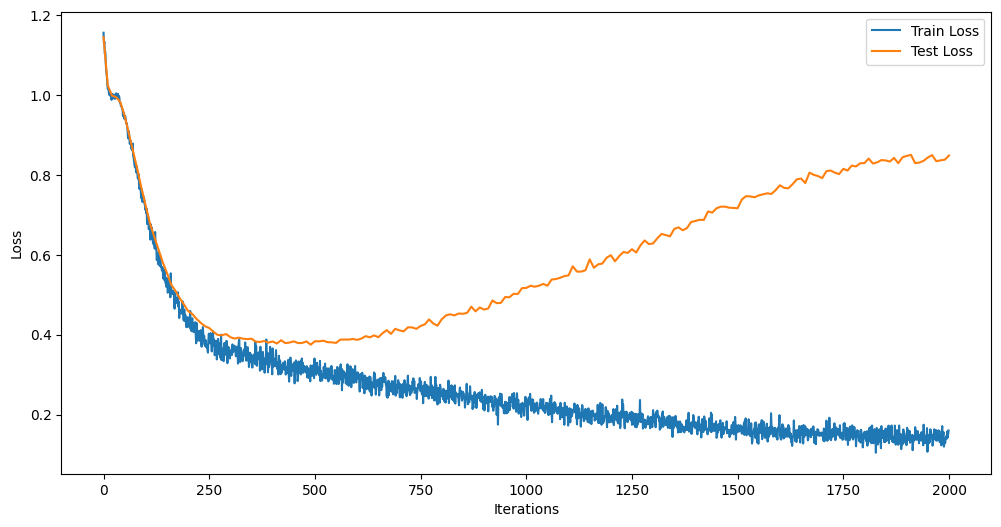

In [204]:
plot_losses(train_losses, test_losses)

In [205]:
train_losses[-1], test_losses[-1]

(0.1600482016801834, 0.8486319670275758)

In [206]:
# Save the model
# save_dir = "models/diffusion/pusht_mlp_5x512/2024-04-15"
save_dir = None
if save_dir is not None:
    os.makedirs(save_dir, exist_ok=False)
    diffusion.save(os.path.join(save_dir, "diffusion_model_final.pt"))
    np.save(os.path.join(save_dir, "train_losses.npy"), train_losses)
    np.save(os.path.join(save_dir, "test_losses.npy"), test_losses)

## Sample

In [219]:
if n_obs_history == 0:
    data_shape = (n_pred_horizon, STATE_DIM)
elif n_pred_horizon != 0:
    data_shape = (n_obs_history, STATE_DIM)
else:
    raise ValueError("This makes no sense.")

return_steps = [512]
num_samples = 100
normalized_samples = sample(
    diffusion,
    num_samples=num_samples,
    return_steps=return_steps,
    data_shape=data_shape,
    data_loader=train_loader,
    clip=None,
    clip_noise=(-3, 3),
    device=device,
    obs_key=obs_key,
)

obs: torch.Size([100, 0])
x: torch.Size([100, 8, 32])


In [216]:
normalized_samples.shape

(1, 100, 8, 32)

(array([2.000e+00, 3.000e+00, 1.000e+00, 6.000e+00, 9.000e+00, 4.000e+00,
        5.000e+00, 1.100e+01, 1.600e+01, 1.400e+01, 1.600e+01, 3.700e+01,
        4.400e+01, 5.600e+01, 1.020e+02, 1.370e+02, 2.050e+02, 3.320e+02,
        5.090e+02, 8.050e+02, 1.250e+03, 2.191e+03, 3.809e+03, 5.287e+03,
        4.126e+03, 2.543e+03, 1.540e+03, 8.840e+02, 5.570e+02, 3.600e+02,
        2.260e+02, 1.720e+02, 1.030e+02, 7.200e+01, 4.900e+01, 2.800e+01,
        2.100e+01, 2.000e+01, 1.300e+01, 1.100e+01, 8.000e+00, 5.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([-898.88220215, -860.79644775, -822.71075439, -784.625     ,
        -746.53930664, -708.45355225, -670.36785889, -632.28210449,
        -594.1963501 , -556.11065674, -518.02490234, -479.93917847,
        -441.85345459, -403.76773071, -365.68200684, -327.59628296,
        -289.51052856, -251.42481995, -213.33908081, -175.25335693,
        -137.16763306,  -99.08190155

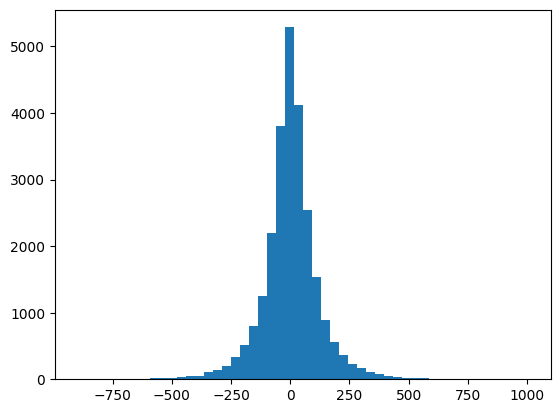

In [217]:
plt.hist(normalized_samples.flatten(), bins=50)

In [210]:
if obs_key == "img":
    # Load VAE
    # vae_model_path = "/nas/ucb/ebronstein/lsdp/models/pusht_vae/vae_32_20240403.pt"
    # latent_dim = 32
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # vae_model = VanillaVAE(
    #     in_channels=3, in_height=H, in_width=W, latent_dim=latent_dim
    # ).to(device)
    # vae_model.load_state_dict(torch.load(vae_model_path))

    # Decode using VAE.

    batch_size = 8
    vae_model.to(device)

    # Decode the samples in batches
    decoded_normalized_samples = []
    num_batches = 10  # num_samples // batch_size
    reshape_batch_shape = (
        [batch_size, n_obs_history]
        if n_obs_history != 0
        else [batch_size, n_pred_horizon]
    )

    for i in trange(0, num_batches, batch_size):
        batch_samples = normalized_samples[
            0, i : i + batch_size
        ]  # [batch_size * n_obs_history, latent_dim]
        batch_samples = batch_samples.reshape((-1, batch_samples.shape[-1]))
        # print("batch_samples:", batch_samples.shape)
        # [batch_size * n_obs_history, C, H, W]
        decoded_batch = vae_model.decode(torch.from_numpy(batch_samples).to(device))
        decoded_batch = decoded_batch.reshape(
            reshape_batch_shape + list(decoded_batch.shape[1:])
        )
        # print("decoded_batch:", decoded_batch.shape)
        decoded_normalized_samples.append(decoded_batch.cpu().detach().numpy())

    decoded_normalized_samples = np.concatenate(decoded_normalized_samples)

    # Denormalize.
    view_recons = decoded_normalized_samples.transpose(0, 1, 3, 4, 2)
    view_recons = (view_recons + 1) / 2
    view_recons *= 255
    view_recons = view_recons.astype(np.uint8)

  0%|          | 0/2 [00:00<?, ?it/s]

In [211]:
decoded_normalized_samples.shape, view_recons.shape

((16, 8, 3, 96, 96), (16, 8, 96, 96, 3))

In [212]:
view_recons.min(axis=(1, 2, 3, 4)), view_recons.max(axis=(1, 2, 3, 4))

(array([66, 67, 42, 53, 57, 57, 63, 62, 63, 62, 62, 60, 56, 65, 65, 60],
       dtype=uint8),
 array([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255], dtype=uint8))

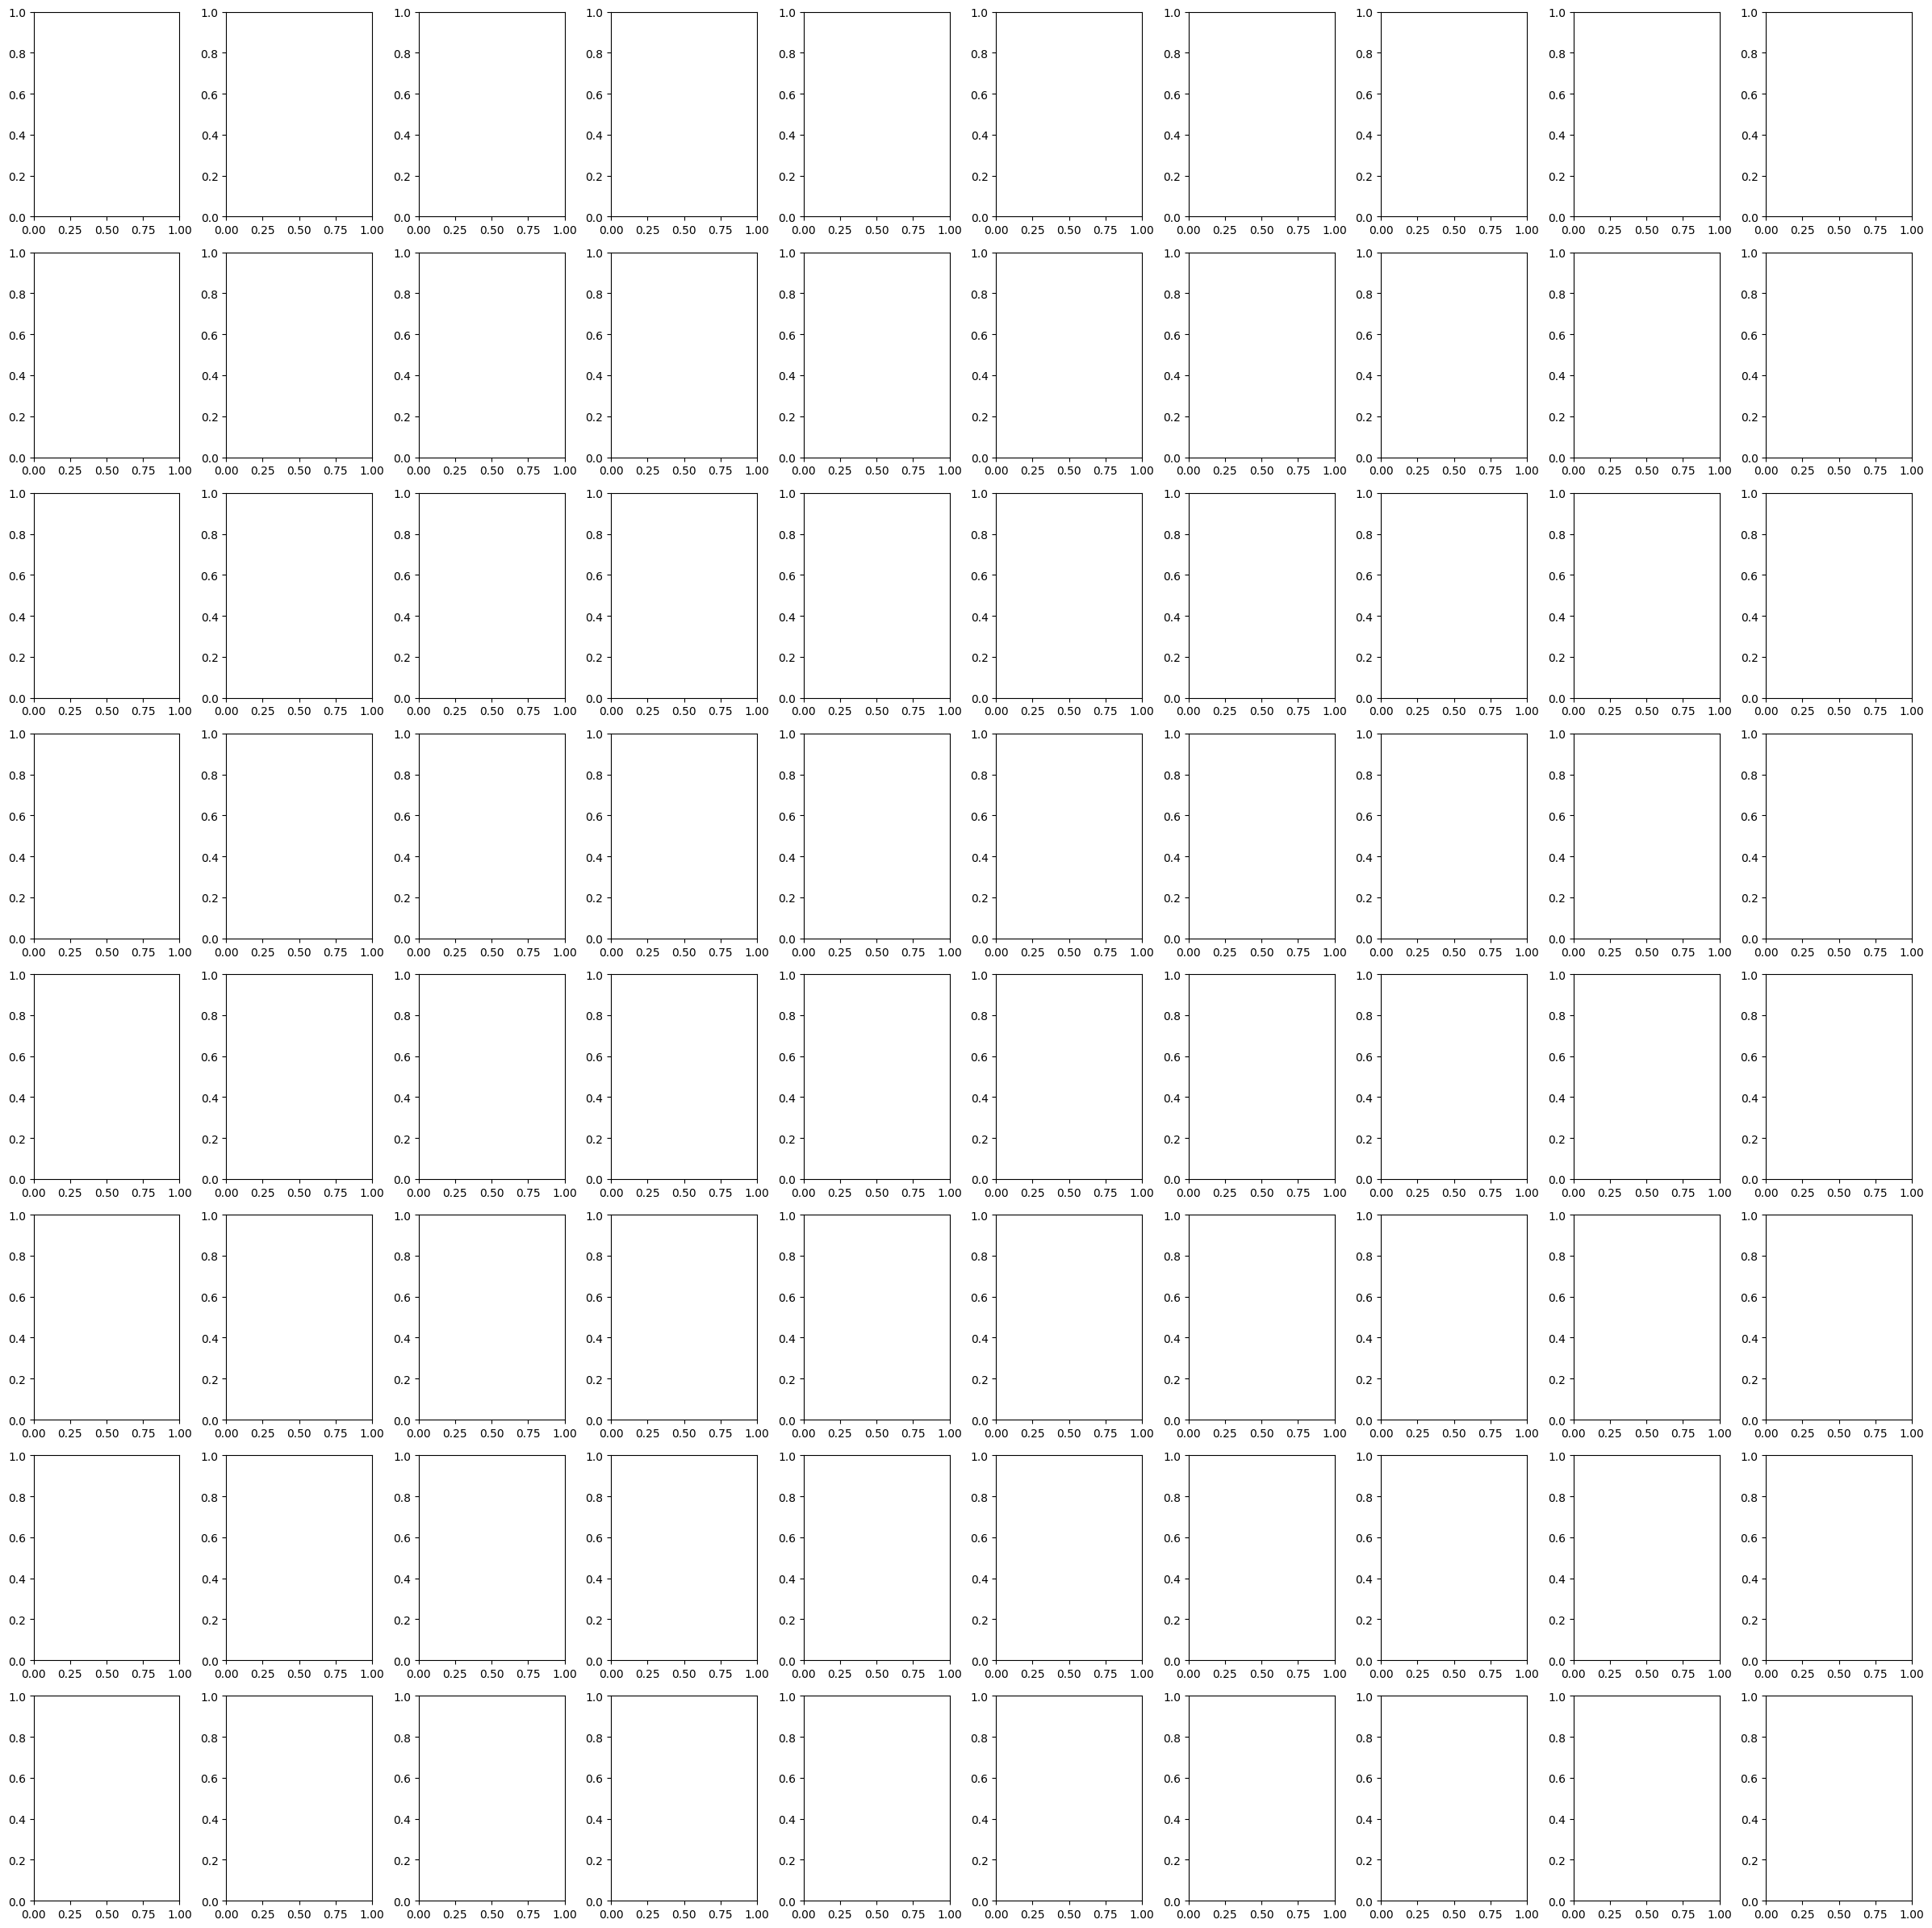

In [213]:
num_rollouts = 10
nrows = n_obs_history if n_obs_history != 0 else n_pred_horizon
fig, axs = plt.subplots(nrows, num_rollouts, figsize=(24, 24), squeeze=False)
for i in range(n_obs_history):
    for j in range(num_rollouts):
        ax = axs[i, j]
        ax.imshow(view_recons[j, i])
        ax.axis("off")
fig.tight_layout()

In [59]:
# TODO: remove NaNs?
for norm_samples_i in normalized_samples:
    print(norm_samples_i.min(), norm_samples_i.max())
# (
#     normalized_samples[~np.isnan(normalized_samples)].min(),
#     normalized_samples[~np.isnan(normalized_samples)].max(),
# )

-2202.7717 2216.6323


In [61]:
# Fraction of samples in-range
((normalized_samples >= -1) & (normalized_samples <= 1)).all(axis=(-2, -1)).sum(axis=-1) / num_samples

array([0.])

In [62]:
in_range_normalized_samples = []
for num_steps in range(normalized_samples.shape[0]):
    mask = ((normalized_samples >= -1) & (normalized_samples <= 1)).all(axis=(-2, -1))
    in_range_normalized_samples.append(normalized_samples[mask])

In [63]:
# [len(return_steps), num_in_range_samples, n_obs_history, dim=5]
in_range_samples = np.array(
    [
        denormalize_pn1(s, min_state, max_state)
        for s in in_range_normalized_samples
    ]
)

ValueError: operands could not be broadcast together with shapes (0,8,32) (5,) 

In [55]:
n_data, state_dim = dataset.replay_buffer["state"].shape
np.broadcast_to(
    dataset.replay_buffer["state"][:, None], [n_data, n_obs_history, state_dim]
).shape

(25650, 8, 5)

In [44]:
samples = np.load(
    "/nas/ucb/ebronstein/lsdp/models/diffusion/pusht-1dconv_state_128_256_512_1024-obs_8-pred_8/2024-04-27_22-07-27/train_samples.npy"
)

In [220]:
normalized_samples.shape

(1, 100, 8, 32)

In [238]:
def plot_samples(samples=None, data=None, max_num_dims=None, save_dir=None):
    if samples is None and data is None:
        raise ValueError("Either samples or data must be provided.")

    # Plot histogram of each dimension of the samples
    for i, steps in enumerate(return_steps):
        if samples is not None:
            step_samples = samples[i]  # [num_samples, n_history, dim]
            n_history = step_samples.shape[1]
            dim = step_samples.shape[2]
        else:
            n_history, dim = data.shape[1:]

        dim = min(dim, max_num_dims)

        fig, ax = plt.subplots(
            n_history, dim, figsize=(dim * 3, n_history * 4), squeeze=False
        )

        for i in range(n_history):
            for j in range(dim):
                if samples is not None:
                    ax[i, j].hist(
                        step_samples[:, i, j],
                        density=True,
                        bins=50,
                        color="blue",
                        alpha=0.5,
                    )
                if data is not None:
                    ax[i, j].hist(
                        data[:, i, j],
                        density=True,
                        bins=50,
                        color="green",
                        alpha=0.5,
                    )
                ax[i, j].set_title(f"History {i}, Dim {j}")

        fig.suptitle(f"{steps} steps")
        if save_dir is not None:
            plt.savefig(os.path.join(save_dir, f"histogram_{steps}.png"))
        else:
            plt.show()

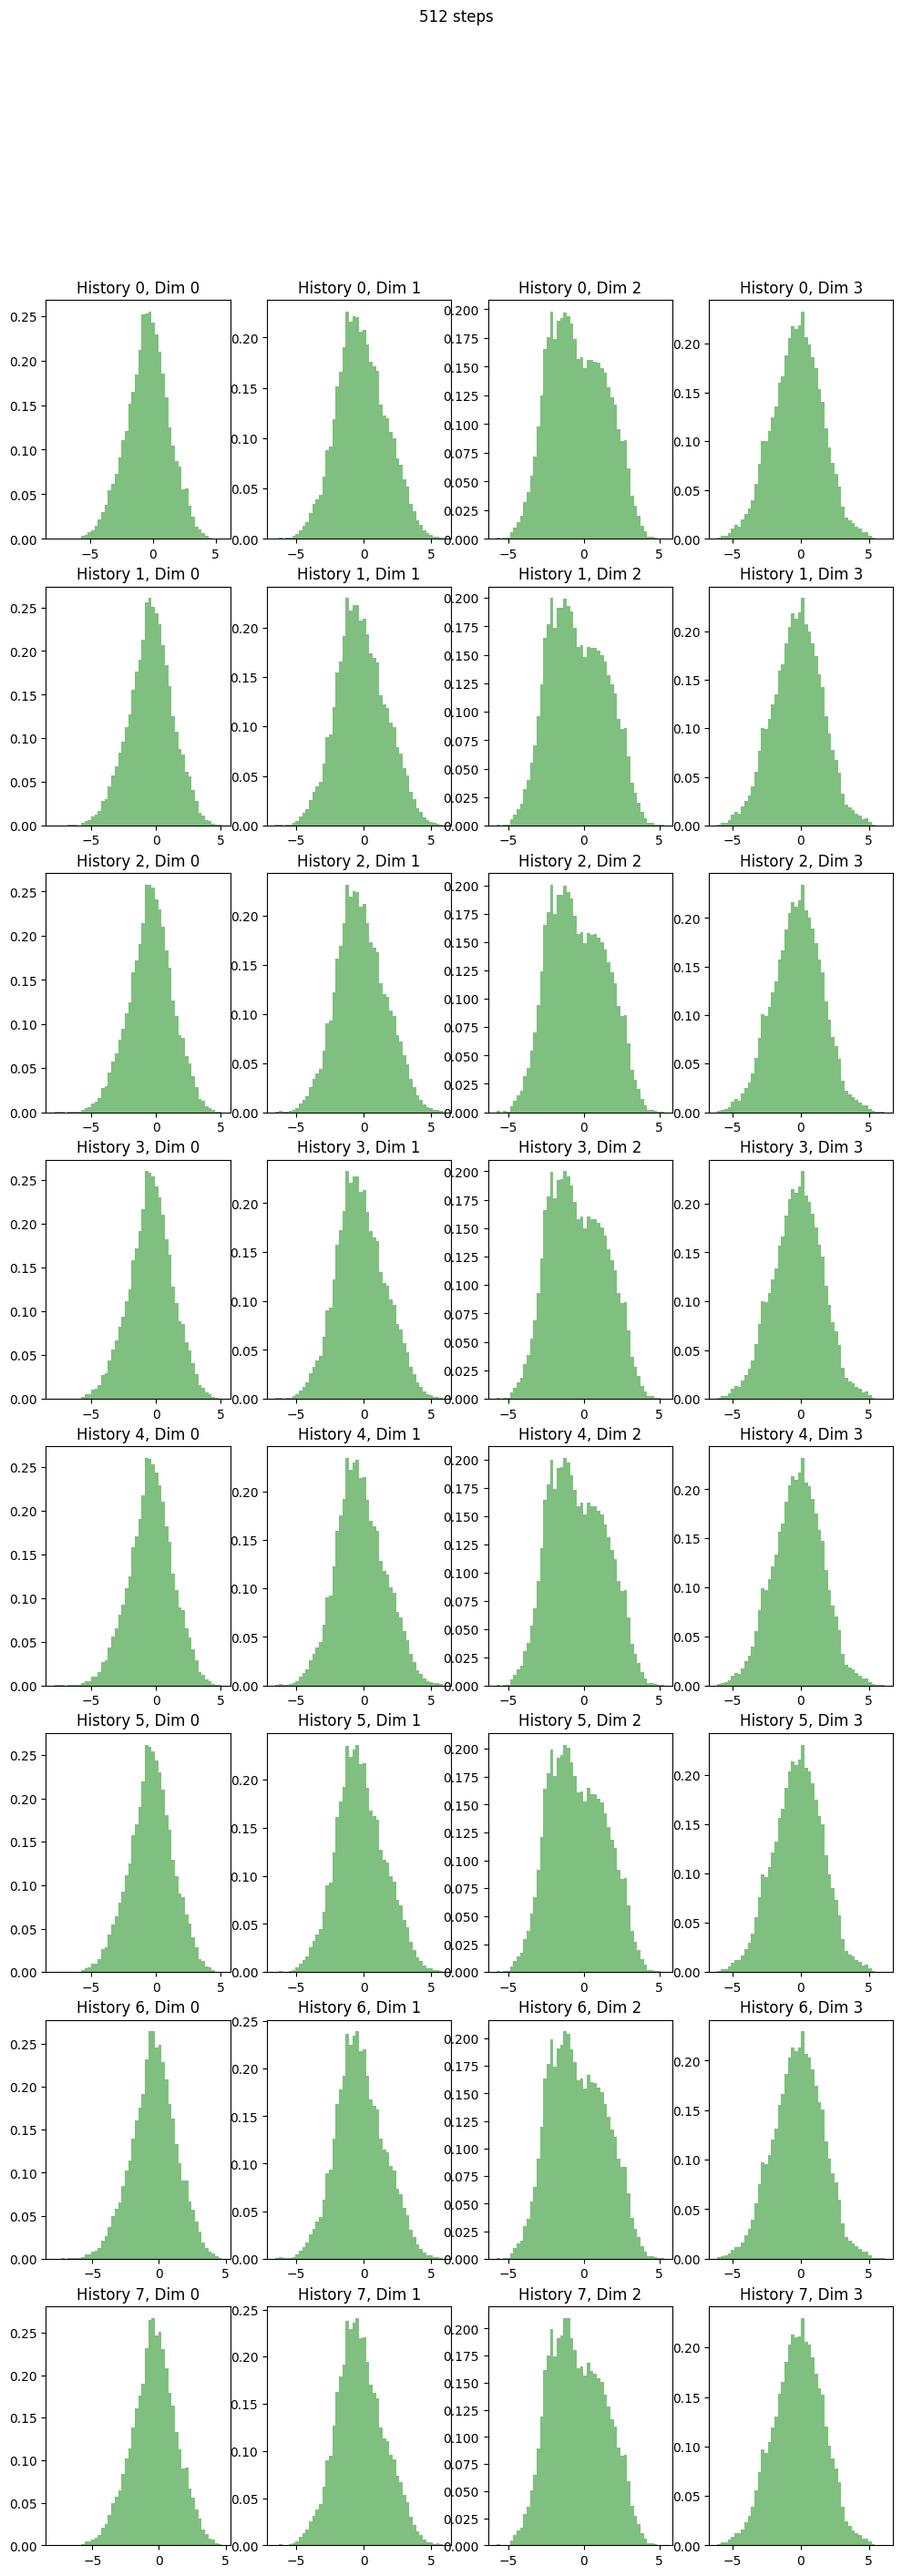

In [239]:
if obs_key == "state":
    n_data, state_dim = dataset.replay_buffer["state"].shape
    plot_samples(
        samples,
        np.broadcast_to(
            dataset.replay_buffer["state"][:, None], [n_data, n_obs_history, state_dim]
        ),
        save_dir=None,
    )
elif obs_key == "img":
    num_data = 10000
    data = []
    for _, pred in train_loader:
        data.append(pred[obs_key].detach().cpu().numpy())
        if len(data) >= num_data:
            break
    data = np.concatenate(data)
    plot_samples(
        samples=None,
        data=data,
        max_num_dims=4,
        save_dir=None,
    )

In [46]:
diff_states = []
for obs_history, pred_horizon in train_loader:
    norm_state = obs_history["state"].detach().cpu().numpy()  # [batch_size, n_history, dim]
    state = denormalize_pn1(norm_state, min_state, max_state)  # [batch_size, n_history, dim]
    diff_states.append(np.diff(state, axis=1))  # [batch_size, n_history - 1, dim]

diff_states = np.concatenate(diff_states, axis=0)  # [n_samples, n_history - 1, dim]

In [51]:
samples.min(axis=(1, 2)), samples.max(axis=(1, 2))

(array([[  0.55809593,  39.82869   ,  63.50651   , 107.62806   ,
          -0.50211596]], dtype=float32),
 array([[495.20792 , 503.51846 , 441.62518 , 486.64386 ,   6.803591]],
       dtype=float32))

In [52]:
diff_samples = np.diff(samples, axis=2)  # [len(return_steps), num_in_range_samples, n_history - 1, dim]

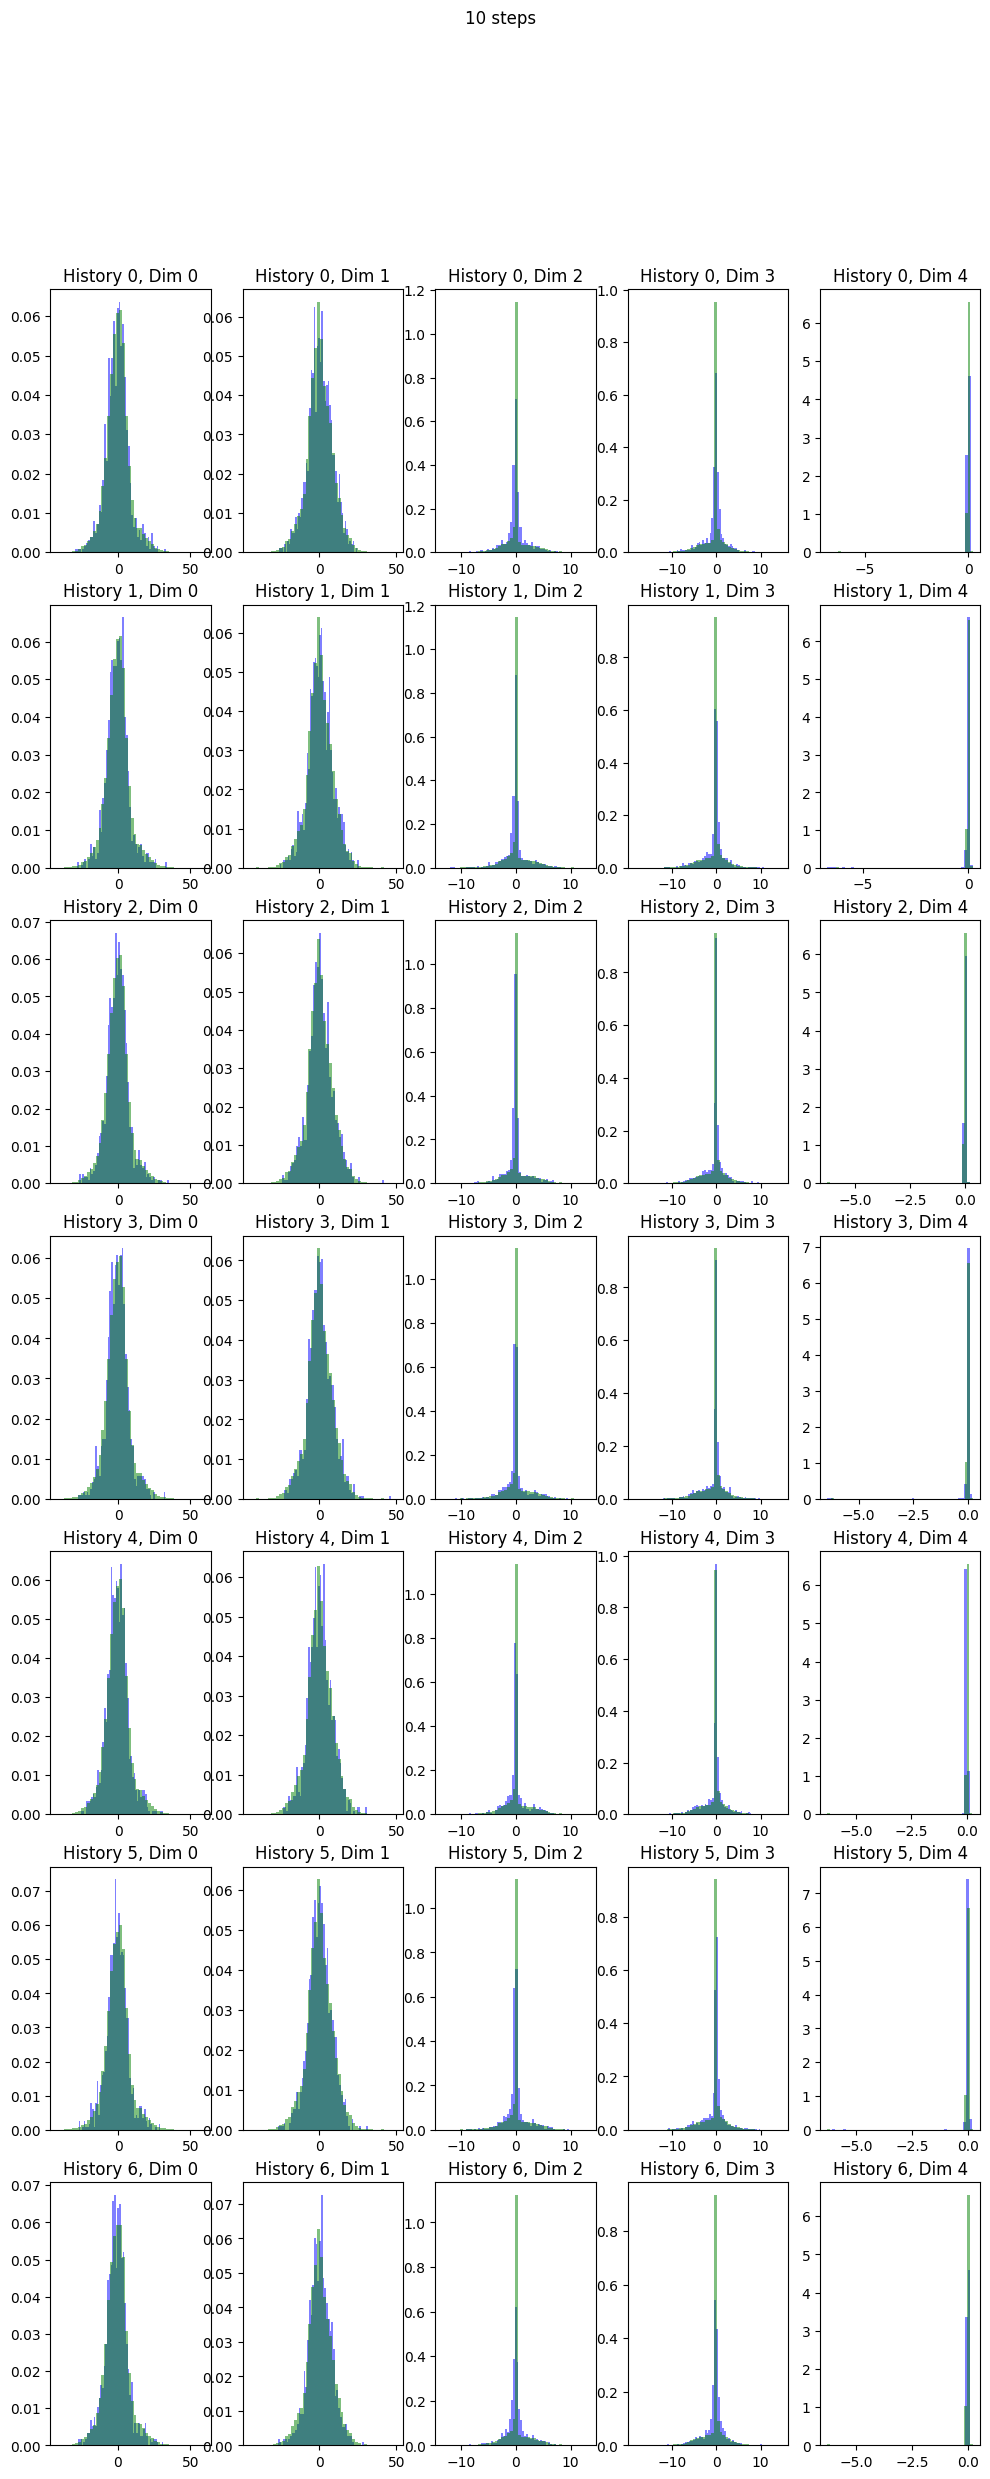

In [53]:
plot_samples(diff_samples, diff_states, save_dir=None)

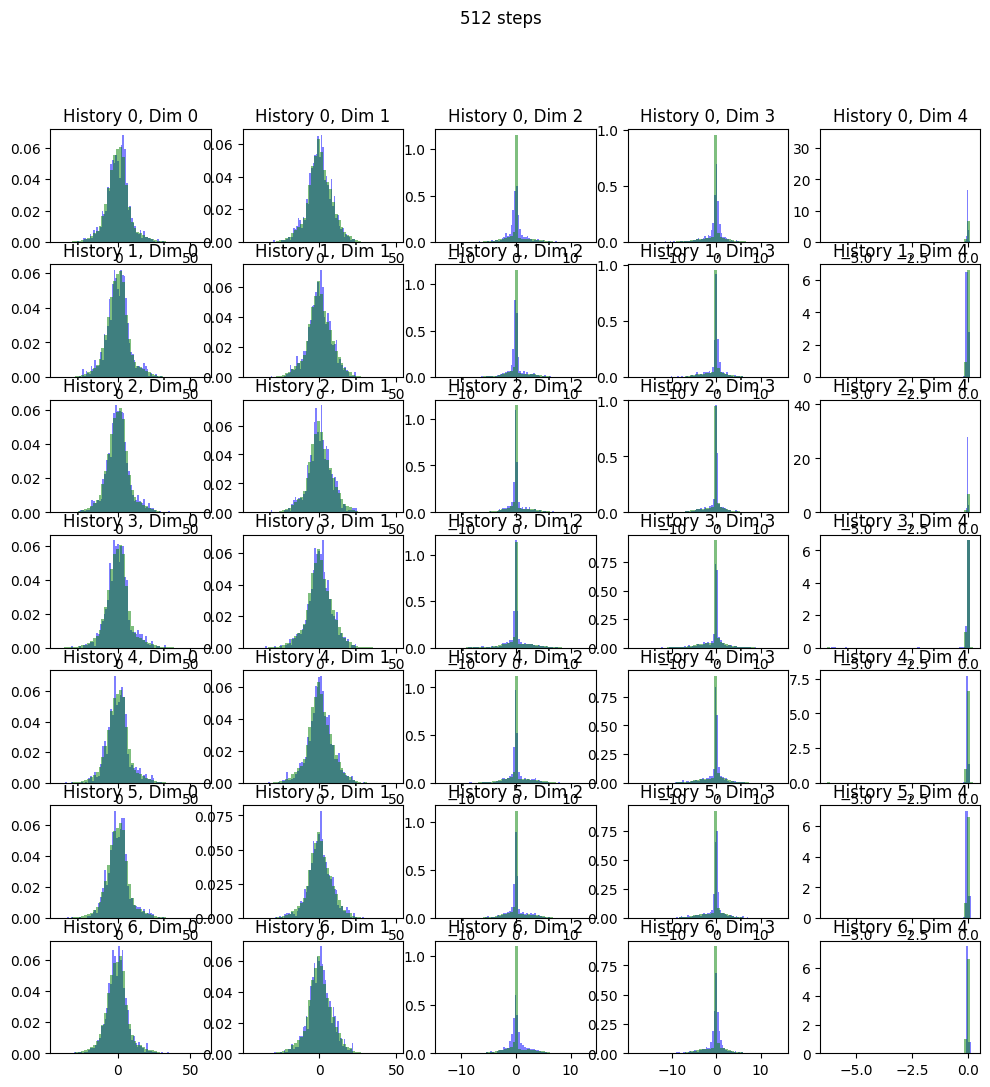

In [60]:
# Plot histogram of each dimension of the samples
for i, steps in enumerate(return_steps):
    step_diff_samples = diff_samples[i]  # [num_samples, n_history - 1, dim]
    assert len(step_diff_samples.shape) == 3
    n_history = step_diff_samples.shape[1]
    dim = step_diff_samples.shape[2]

    fig, axs = plt.subplots(n_history, dim, figsize=(12, 12))

    for i in range(n_history):
        for j in range(dim):
            ax = axs[i, j]
            # Samples
            ax.hist(
                step_diff_samples[:, i, j],
                density=True,
                bins=50,
                color="blue",
                alpha=0.5,
                # label=f"samples {i}",
            )
            # Real data
            ax.hist(
                diff_states[:, i, j],
                density=True,
                bins=50,
                color="green",
                alpha=0.5,
                # label=f"replay {i}",
            )

            ax.set_title(f"History {i}, Dim {j}")
            # ax.legend()

    fig.suptitle(f"{steps} steps")
    plt.show()

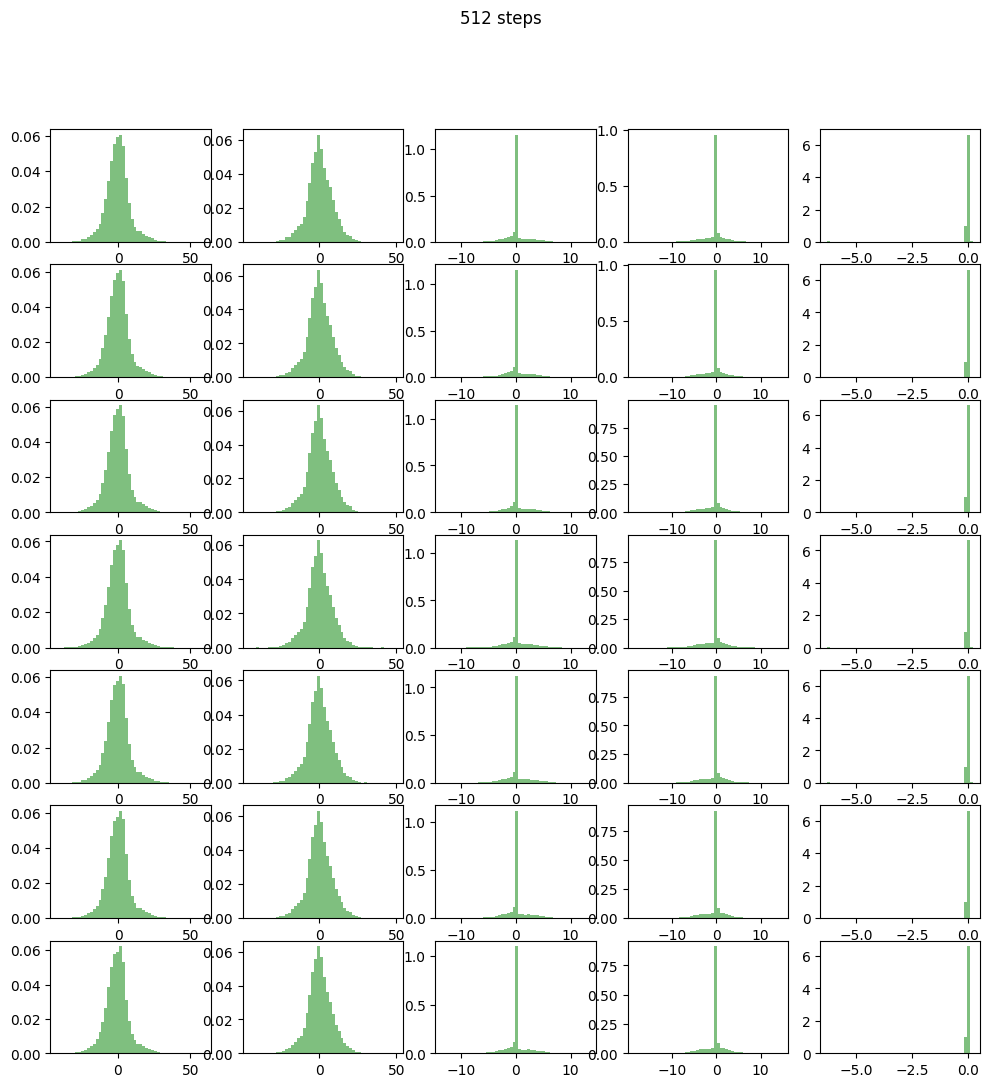

In [61]:
# Plot histogram of each dimension of the samples
for i, steps in enumerate(return_steps):
    fig, axs = plt.subplots(n_history, dim, figsize=(12, 12))

    for i in range(n_history):
        for j in range(dim):
            ax = axs[i, j]
            ax.hist(
                diff_states[:, i, j],
                density=True,
                bins=50,
                color="green",
                alpha=0.5,
                # label=f"replay {i}",
            )

            # ax.set_title(f"History {i}, Dim {j}")
            # ax.legend()

    fig.suptitle(f"{steps} steps")
    plt.show()

In [62]:
# Plot a few sampled and real trajectories.
n_samples = 30
obs_history, pred_horizon = next(iter(train_loader))
norm_state = obs_history["state"][:n_samples].cpu().numpy()  # [n_samples, n_history, dim]
state = denormalize_pn1(norm_state, min_state, max_state)  # [n_samples, n_history, dim]

IndexError: index 5 is out of bounds for axis 2 with size 5

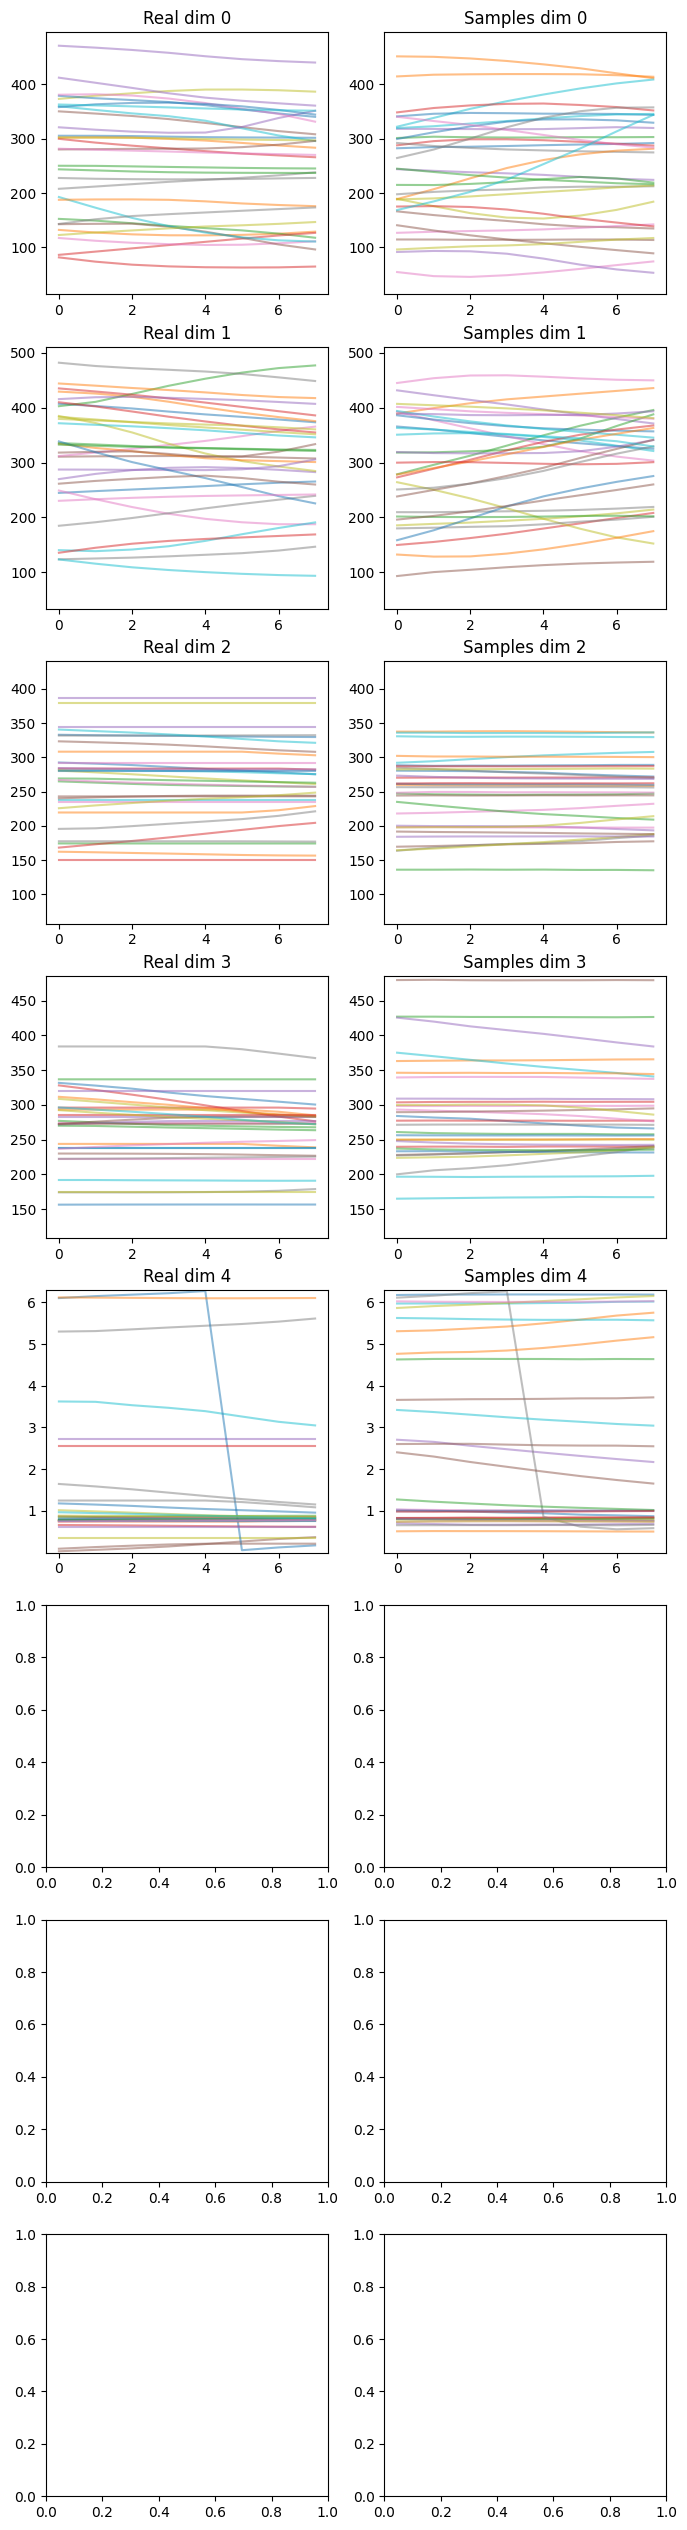

In [63]:
# Plot a few sampled and real trajectories.
n_samples = 30
obs_history, pred_horizon = next(iter(train_loader))
norm_state = obs_history["state"][:n_samples].cpu().numpy()  # [n_samples, n_history, dim]
state = denormalize_pn1(norm_state, min_state, max_state)  # [n_samples, n_history, dim]

dim = state.shape[1]
fig, axs = plt.subplots(dim, 2, figsize=(8, dim * 4))

for i in range(dim):
    real_ax = axs[i, 0]
    real_i = state[:, :, i]
    real_ax.plot(real_i.T, alpha=0.5, label="real")
    real_ax.set_title(f"Real dim {i}")

    sample_ax = axs[i, 1]
    samples_i = in_range_samples[0, :n_samples, :, i]
    sample_ax.plot(samples_i.T, alpha=0.5, label="sample")
    sample_ax.set_title(f"Samples dim {i}")

    # Set the same ylim for both axes.
    # min_y = min(real_i.min(), samples_i.min())
    # max_y = max(real_i.max(), samples_i.max())
    min_y = min_state[i]
    max_y = max_state[i]
    real_ax.set_ylim(min_y, max_y)
    sample_ax.set_ylim(min_y, max_y)

### Debug sampling

In [ ]:
for p in diffusion.model.parameters():
    # print(p)
    if torch.isnan(p).any():
        print("NaNs in the parameters.")
    else:
        param_norm = p.norm(2)
        print(param_norm)

tensor(15.0387, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(3.3600, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(18.0978, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.9246, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(17.4330, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.7837, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(17.0868, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.7176, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(4.5212, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0.1267, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
